<a href="https://colab.research.google.com/github/SalhaAlzahrani/ConvAttenMixer/blob/main/ConvMixer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ConvMixer

https://keras.io/examples/vision/convmixer/
In the Patches Are All You Need paper (note: at the time of writing, it is a submission to the ICLR 2022 conference), the authors extend the idea of using patches to train an all-convolutional network and demonstrate competitive results. Their architecture namely ConvMixer uses recipes from the recent isotrophic architectures like ViT, MLP-Mixer (Tolstikhin et al.), such as using the same depth and resolution across different layers in the network, residual connections, and so on.



In [ ]:
pip install -U tensorflow-addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.0 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory

import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import numpy as np
from google.colab import drive

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


# Hyperparameters
To keep run time short, we will train the model for only 10 epochs. To focus on the core ideas of ConvMixer, we will not use other training-specific elements like RandAugment (Cubuk et al.). If you are interested in learning more about those details, please refer to the original paper.


In [ ]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 128
num_epochs = 30
label_smoothing = 0.1
num_classes = 4
input_shape = (224, 224, 3)
img_size=224

# Prepare the data

In [ ]:
drive.mount('/content/drive', force_remount=True)


# train data
train_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Training/',
    #directory='Brain Tumor MRI/data/Training/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    #validation_split=0.1,
    #subset="training",
    seed=1024
)

# test data
val_ds = image_dataset_from_directory(
    directory='/content/drive/MyDrive/Brain Tumor MRI/data/Testing/',
    #directory='Brain Tumor MRI/data/Testing/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224),
    #validation_split=0.1,
    #subset="validation",
    seed=1024
)

Mounted at /content/drive
Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# ConvMixer utilities
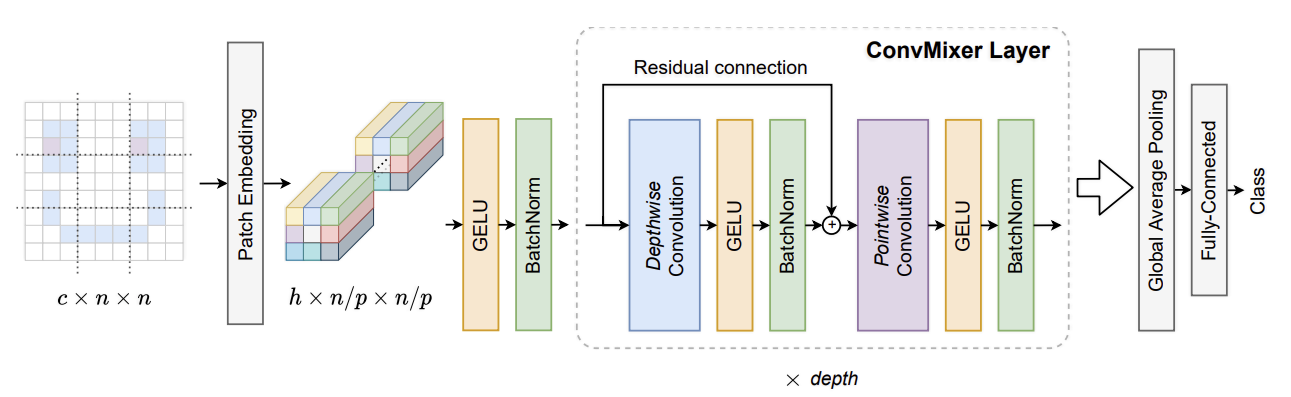

The model used in this experiment is termed as ConvMixer-256/8 where 256 denotes the number of channels and 8 denotes the depth. The resulting model only has 0.8 million parameters.


In [ ]:
def activation_block(x):
    x = layers.Activation("gelu")(x)
    return layers.BatchNormalization()(x)

def conv_stem(x, filters: int, patch_size: int):
    x = layers.Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x)

def conv_mixer_block(x, filters: int, kernel_size: int):
    # Depthwise convolution.
    x0 = x
    x = layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = layers.Add()([activation_block(x), x0])  # Residual.

    # Pointwise convolution.
    x = layers.Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)
    return x

def get_conv_mixer_256_8(
    image_size=img_size, filters=256, depth=8, kernel_size=5, patch_size=2, num_classes=4
):
    """ConvMixer-256/8: https://openreview.net/pdf?id=TVHS5Y4dNvM.
    The hyperparameter values are taken from the paper.
    """
    inputs = keras.Input((image_size, image_size, 3))
    x = layers.Rescaling(scale=1.0 / 255)(inputs)

    # Extract patch embeddings.
    x = conv_stem(x, filters, patch_size)

    # ConvMixer blocks.
    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size)

    # Classification block.
    x = layers.GlobalAvgPool2D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs, outputs)


In [ ]:
model = get_conv_mixer_256_8()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 25  3328        ['rescaling[0][0]']              
                                6)                                                                
                                                                                              

In [ ]:
optimizer = tfa.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes=4, average='macro', threshold=0.5),
    ],
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    batch_size=batch_size,
    epochs=num_epochs
)

Epoch 1/30
179/179 [==============================] - 525s 3s/step - loss: 0.7983 - accuracy: 0.7675 - precision: 0.8432 - recall: 0.6714 - f1_score: 0.7332 - val_loss: 2.4656 - val_accuracy: 0.2288 - val_precision: 0.2288 - val_recall: 0.2288 - val_f1_score: 0.0931
Epoch 2/30
179/179 [==============================] - 92s 513ms/step - loss: 0.6484 - accuracy: 0.8673 - precision: 0.9013 - recall: 0.8102 - f1_score: 0.8466 - val_loss: 4.4438 - val_accuracy: 0.2288 - val_precision: 0.2288 - val_recall: 0.2288 - val_f1_score: 0.0931
Epoch 3/30
179/179 [==============================] - 92s 513ms/step - loss: 0.5990 - accuracy: 0.8904 - precision: 0.9178 - recall: 0.8505 - f1_score: 0.8789 - val_loss: 2.9383 - val_accuracy: 0.2349 - val_precision: 0.2337 - val_recall: 0.2326 - val_f1_score: 0.0999
Epoch 4/30
179/179 [==============================] - 92s 513ms/step - loss: 0.5443 - accuracy: 0.9200 - precision: 0.9438 - recall: 0.8932 - f1_score: 0.9144 - val_loss: 0.7870 - val_accuracy: 0

# Let's visualize the training progress of the model.


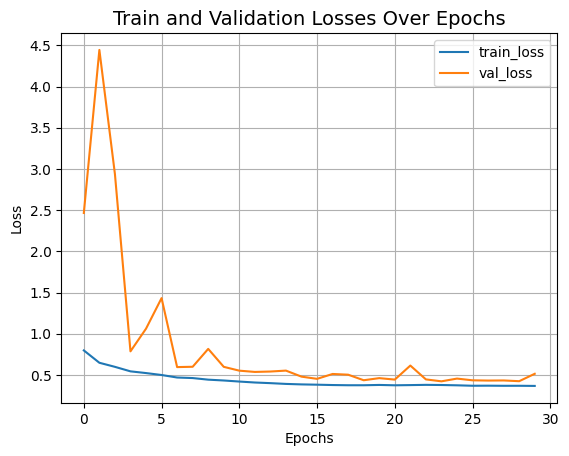

In [ ]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()